In [1]:
#Import data file and set directory

import zipfile
import os

# Unzip stock.zip into nifty_data directory
with zipfile.ZipFile('marketing.zip', 'r') as zip_ref:
    zip_ref.extractall('marketing_data')

# Verify the contents of the directory
os.listdir('marketing_data')

['online_advertising_performance_data.csv',
 'Online Advertising Performance Data.txt']

In [4]:
import pandas as pd
import numpy as np

# Loading the dataset
df = pd.read_csv('/content/marketing_data/online_advertising_performance_data.csv')

# Step 1.1: Remove irrelevant columns and handle missing values
df.drop(columns=['Unnamed: 12', 'Unnamed: 13'], inplace=True)
df.fillna(0, inplace=True)  # Fill missing values with 0 for simplicity

# Step 1.2: Convert 'month' and 'day' to datetime for better time series analysis
df['date'] = pd.to_datetime(df['month'] + ' ' + df['day'].astype(str) + ' 2023', format='%B %d %Y') # Assuming year 2023 and handling month names

# Step 1.3: Feature Engineering (e.g., cost per click, revenue per click)
df['cost_per_click'] = df['cost'] / (df['clicks'] + 1e-5)  # Avoid division by zero
df['revenue_per_click'] = df['revenue'] / (df['clicks'] + 1e-5)
df['conversion_rate'] = df['post_click_conversions'] / (df['clicks'] + 1e-5)

# Check cleaned data
df.head()

,month,day,campaign_number,user_engagement,banner,placement,displays,cost,clicks,revenue,post_click_conversions,post_click_sales_amount,date,cost_per_click,revenue_per_click,conversion_rate
0,April,1,camp 1,High,160 x 600,abc,4,0.0060,0,0.0000,0,0.0000,2023-04-01,600.000000,0.000000,0.000000
1,April,1,camp 1,High,160 x 600,def,20170,26.7824,158,28.9717,23,1972.4602,2023-04-01,0.169509,0.183365,0.145570
2,April,1,camp 1,High,160 x 600,ghi,14701,27.6304,158,28.9771,78,2497.2636,2023-04-01,0.174876,0.183399,0.493671
3,April,1,camp 1,High,160 x 600,mno,171259,216.8750,1796,329.4518,617,24625.3234,2023-04-01,0.120754,0.183436,0.343541
4,April,1,camp 1,Low,160 x 600,def,552,0.0670,1,0.1834,0,0.0000,2023-04-01,0.066999,0.183398,0.000000


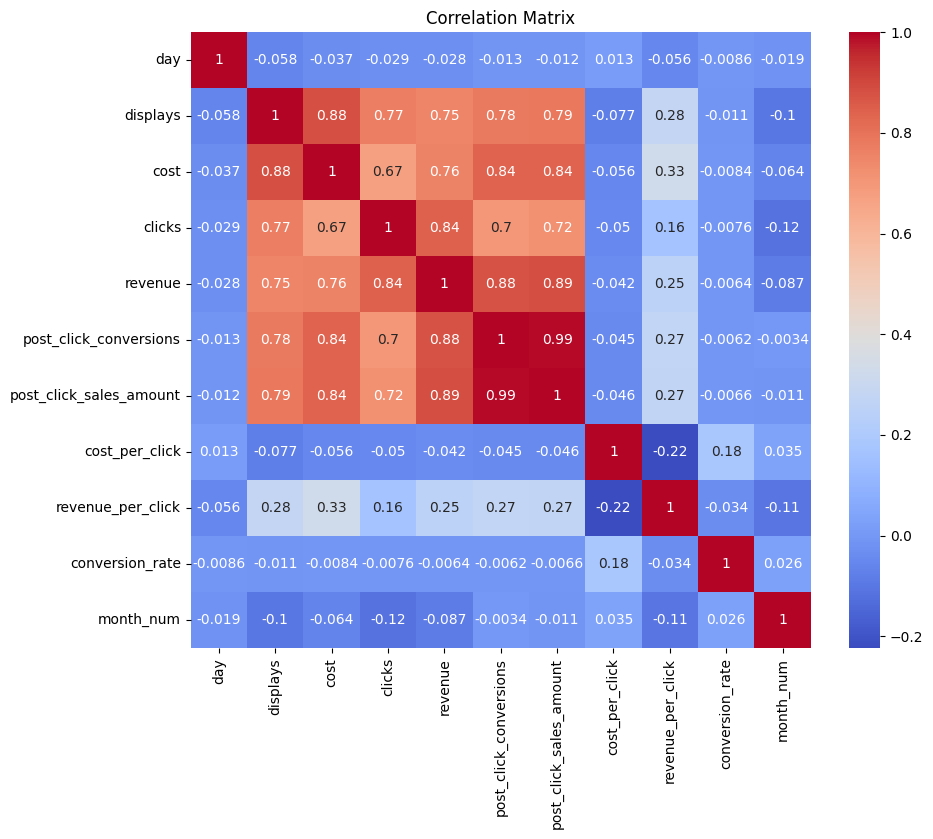

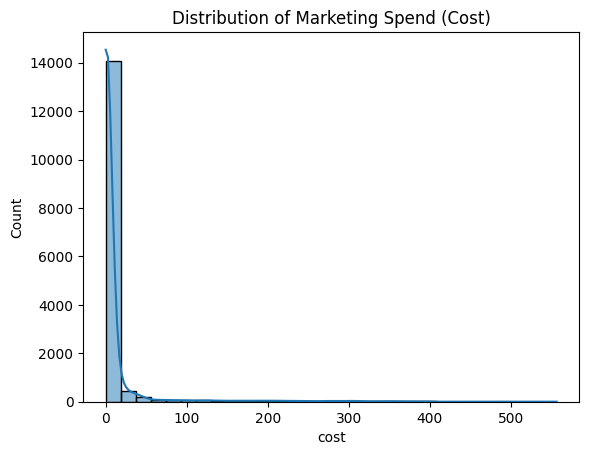

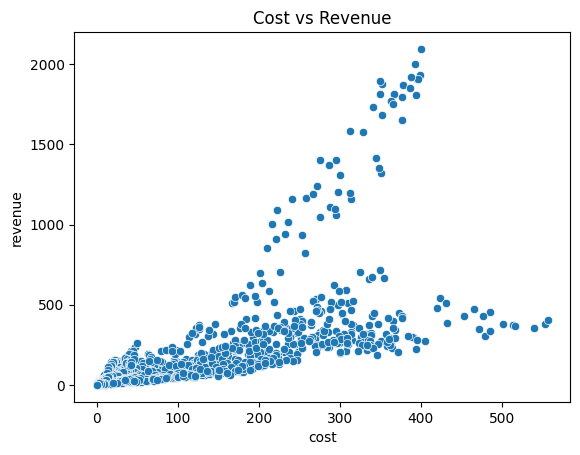

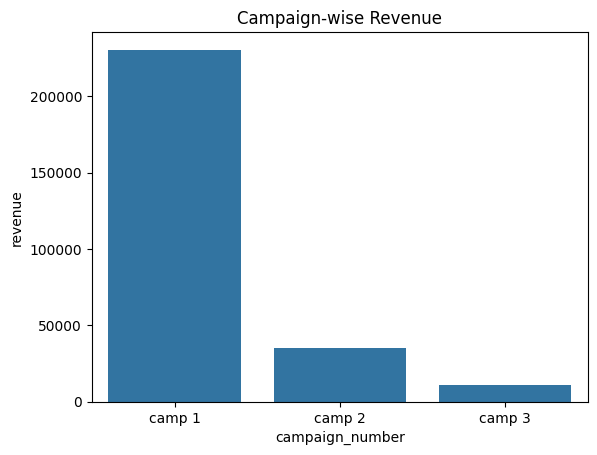

,campaign_number,cost,clicks,revenue,post_click_conversions,revenue_per_dollar_spent
1,camp 2,17037.3496,881158,34890.4153,13767,2.047878
0,camp 1,150688.5798,1409136,230535.3563,633085,1.529879
2,camp 3,7467.0663,202543,10838.7905,4916,1.451546


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2.1: Correlation matrix to understand relationships
plt.figure(figsize=(10, 8))

# Convert 'month' column to numerical representation before calculating correlation
df['month_num'] = df['date'].dt.month

# Calculate correlation on numeric columns only
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

# Step 2.2: Distribution of key features (cost, revenue, clicks)
sns.histplot(df['cost'], bins=30, kde=True)
plt.title('Distribution of Marketing Spend (Cost)')
plt.show()

sns.scatterplot(x='cost', y='revenue', data=df)
plt.title('Cost vs Revenue')
plt.show()

# Step 2.3: Campaign performance analysis
campaign_performance = df.groupby('campaign_number').agg({
    'cost': 'sum',
    'clicks': 'sum',
    'revenue': 'sum',
    'post_click_conversions': 'sum'
}).reset_index()

sns.barplot(x='campaign_number', y='revenue', data=campaign_performance)
plt.title('Campaign-wise Revenue')
plt.show()

# Analyze which campaigns are the most efficient
campaign_performance['revenue_per_dollar_spent'] = campaign_performance['revenue'] / (campaign_performance['cost'] + 1e-5)
campaign_performance.sort_values('revenue_per_dollar_spent', ascending=False)

In [8]:
# Step 3.1: Descriptive Statistics
print(df.describe())

# Step 3.2: Inferential Statistics (t-tests, ANOVA, etc.)
from scipy.stats import ttest_ind

# Example: Compare the means of cost per click across different campaigns
campaign_1 = df[df['campaign_number'] == 1]['cost_per_click']
campaign_2 = df[df['campaign_number'] == 2]['cost_per_click']

# Perform t-test to compare the two campaigns
t_stat, p_value = ttest_ind(campaign_1, campaign_2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation: If p-value < 0.05, we reject the null hypothesis (significant difference)


                day       displays          cost        clicks       revenue  \
count  15408.000000   15408.000000  15408.000000  15408.000000  15408.000000   
mean      15.518886   15512.573014     11.370262    161.788487     17.929943   
min        1.000000       0.000000      0.000000      0.000000      0.000000   
25%        8.000000      78.000000      0.024000      0.000000      0.000000   
50%       15.000000    1182.000000      0.339850      6.000000      0.483950   
75%       23.000000    8960.250000      2.536225     53.000000      3.839800   
max       31.000000  455986.000000    556.704800  14566.000000   2096.211600   
std        8.740909   44392.392890     45.369499    728.276911     96.781834   

       post_click_conversions  post_click_sales_amount  \
count            15408.000000             15408.000000   
mean                42.300623              2123.288058   
min                  0.000000                 0.000000   
25%                  0.000000                 0

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for modeling
X = df[['cost', 'clicks', 'displays']]  # Features
y = df['revenue']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predictions and evaluation
y_pred = regressor.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R-squared: {r2_score(y_test, y_pred)}")


Mean Squared Error: 1823.755474917949
R-squared: 0.777526923591852


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Assume we create a new target for classification: "Profitable" based on a revenue threshold
df['profitable'] = df['revenue'].apply(lambda x: 1 if x > 1000 else 0)  # Example threshold

# Prepare features and target
X = df[['cost', 'clicks', 'user_engagement']]  # Features
y = df['profitable']  # Target (Profitable or Not)

# Encode categorical feature 'user_engagement'
label_encoder = LabelEncoder() # Initialize LabelEncoder
X['user_engagement'] = label_encoder.fit_transform(X['user_engagement']) # Fit and transform

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

<ipython-input-11-25b6ddb1ae8e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['user_engagement'] = label_encoder.fit_transform(X['user_engagement']) # Fit and transform


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3074
           1       1.00      1.00      1.00         8

    accuracy                           1.00      3082
   macro avg       1.00      1.00      1.00      3082
weighted avg       1.00      1.00      1.00      3082



In [12]:
# Calculate revenue per dollar spent for each campaign
df['revenue_per_dollar_spent'] = df['revenue'] / (df['cost'] + 1e-5)

# Group by campaign and calculate the mean revenue per dollar spent
campaign_performance = df.groupby('campaign_number').agg({
    'revenue': 'sum',
    'cost': 'sum',
    'revenue_per_dollar_spent': 'mean'
}).reset_index()

# Sort campaigns by revenue per dollar spent to identify the most cost-effective campaigns
top_campaigns = campaign_performance.sort_values('revenue_per_dollar_spent', ascending=False)
print(top_campaigns)

# Recommend top campaigns for increased budget allocation
recommended_budget_increase = top_campaigns[top_campaigns['revenue_per_dollar_spent'] > 1.0]  # Threshold of 1.0 can be adjusted
print(f"Recommended campaigns for budget increase: \n{recommended_budget_increase}")


  campaign_number      revenue         cost  revenue_per_dollar_spent
2          camp 3   10838.7905    7467.0663                  2.550641
0          camp 1  230535.3563  150688.5798                  2.137628
1          camp 2   34890.4153   17037.3496                  1.582079
Recommended campaigns for budget increase: 
  campaign_number      revenue         cost  revenue_per_dollar_spent
2          camp 3   10838.7905    7467.0663                  2.550641
0          camp 1  230535.3563  150688.5798                  2.137628
1          camp 2   34890.4153   17037.3496                  1.582079


In [16]:
# Calculate revenue per user engagement
df['revenue_per_engagement'] = df['revenue'] / (df['user_engagement'].replace({'High': 1.0, 'Medium': 0.5, 'Low': 0.1}).astype(float) + 1e-5) # Convert 'user_engagement' to float after replacing string values with numerical equivalents

# Group by campaign and calculate the mean revenue per engagement
engagement_performance = df.groupby('campaign_number').agg({
    'revenue': 'sum',
    'user_engagement': 'sum',
    'revenue_per_engagement': 'mean',
    'post_click_sales_amount': 'sum'
}).reset_index()

# Sort campaigns by revenue per engagement
top_engagement_campaigns = engagement_performance.sort_values('revenue_per_engagement', ascending=False)
print(top_engagement_campaigns)

# Highlight campaigns with high engagement ROI
high_engagement_campaigns = top_engagement_campaigns[top_engagement_campaigns['revenue_per_engagement'] > 1.0]
print(f"High engagement ROI campaigns: \n{high_engagement_campaigns}")

  campaign_number      revenue  \
1          camp 2   34890.4153   
0          camp 1  230535.3563   
2          camp 3   10838.7905   

                                     user_engagement  revenue_per_engagement  \
1  LowLowLowMediumMediumMediumMediumLowLowLowLowM...               55.307786   
0  HighHighHighHighLowLowLowMediumMediumMediumHig...               37.404334   
2  HighHighHighLowLowLowLowMediumMediumMediumMedi...                5.049744   

   post_click_sales_amount  
1             1.167509e+06  
0             3.101275e+07  
2             5.353672e+05  
High engagement ROI campaigns: 
  campaign_number      revenue  \
1          camp 2   34890.4153   
0          camp 1  230535.3563   
2          camp 3   10838.7905   

                                     user_engagement  revenue_per_engagement  \
1  LowLowLowMediumMediumMediumMediumLowLowLowLowM...               55.307786   
0  HighHighHighHighLowLowLowMediumMediumMediumHig...               37.404334   
2  HighHighHighLo

In [14]:
# Analyze revenue by ad placement and banner
placement_performance = df.groupby('placement').agg({
    'revenue': 'sum',
    'cost': 'sum',
    'revenue_per_dollar_spent': 'mean'
}).reset_index()

banner_performance = df.groupby('banner').agg({
    'revenue': 'sum',
    'cost': 'sum',
    'revenue_per_dollar_spent': 'mean'
}).reset_index()

# Sort by revenue per dollar spent to identify the most effective ad placements and banners
top_placements = placement_performance.sort_values('revenue_per_dollar_spent', ascending=False)
top_banners = banner_performance.sort_values('revenue_per_dollar_spent', ascending=False)

print("Top performing ad placements based on revenue per dollar spent:")
print(top_placements)

print("Top performing banners based on revenue per dollar spent:")
print(top_banners)

# Recommend ad placements and banners with the highest ROI for future campaigns
recommended_placements = top_placements[top_placements['revenue_per_dollar_spent'] > 1.0]
recommended_banners = top_banners[top_banners['revenue_per_dollar_spent'] > 1.0]

print(f"Recommended ad placements: \n{recommended_placements}")
print(f"Recommended banners: \n{recommended_banners}")


Top performing ad placements based on revenue per dollar spent:
  placement      revenue        cost  revenue_per_dollar_spent
5       mno  100460.1798  95006.6592                  3.553917
2       def   15861.2356  14207.9946                  2.645487
3       ghi  151548.1020  62218.6194                  1.538290
4       jkl    8254.4889   3629.5653                  1.421229
1       abc     140.2604    127.3760                  0.523629
0         0       0.2954      2.7812                  0.280335
Top performing banners based on revenue per dollar spent:
      banner      revenue        cost  revenue_per_dollar_spent
7  800 x 250       1.0826      2.8004                 15.742165
0  160 x 600   23516.1292  17516.4329                  3.676372
4  580 x 400   11193.1428   8978.5730                  2.594299
1  240 x 400  129930.2464  56415.6148                  1.879821
2  300 x 250   43171.3532  35438.5266                  1.829307
5   670 x 90    4022.8618   3817.9569                